## Introduction 

For this project, we're given real estate data from King County. Our job is to create and solve a business problem using a linear regression model. We have total freedom in who our stakeholders are, and what the business problem is. For this project, I'll be using CRoss-Industry Standard Process for Data Mining (CRISP-DM) as my Data Science Process. 

## Business Understanding

As discussed with my group, our project will cater to first time home buyers, generally in their 20's and 30's and perhaps thinking of starting a family. Our regression model will help inform home buyers on which features most impact the overall price, so they can be more strategic when buying their first home. Our hope is to showcase what features may add additional costs, so buyers can reflect whether each feature is worth it or not.  

## Data Understanding 

Our original dataset contains real estate info for houses in 2014-2015, with features including square footage of lot and living, number of bedrooms and bathrooms, grade and condition, whether it's in the waterfront or not, just to name a few. 

Given that we are catering to first time home buyers, we've also added features not included in the dataset, including distance to prime locations, criminality rate, school ratings and walking score. Given the plethora of features, we'll need to hone in and figure out which features most impact price. 

#### Original DataFrame + School Info + Distance Info

In [1]:
# Merging datasets (Eric's df including school data and distance data)
import pandas as pd
df = pd.read_csv('/users/christianmoya/Documents/Flatiron/kc_housing.csv')
df.set_index('Unnamed: 0')

df_zip = pd.read_csv('/users/christianmoya/Documents/Flatiron/projects/dsc-phase-2-project/cleaned_kc_housing.csv')
df_zip.set_index('id')

df['zip'] = df_zip['zipcode']

df.head()

,Unnamed: 0,price,bedrooms,bathrooms,sqft_lot,sqft_living,floors,waterfront,condition,grade,...,district,grades,grade_num,total_sch,total_student,transport_dist,medical_emerg_dist,entertain_dist,job_center_dist,zip
0,0,538000.0,3,2.25,7242,2570,2.0,0.0,3,7,...,seattle,A-,11,108,"55,271",4.627271,1.990067,2.407421,4.627271,98125
1,1,180000.0,2,1.00,10000,770,1.0,0.0,3,6,...,northshore,A,12,39,23500,5.204685,2.792852,2.605384,5.204685,98028
2,2,604000.0,4,3.00,5000,1960,1.0,0.0,5,7,...,seattle,A-,11,108,"55,271",4.845578,2.957678,2.858197,4.845578,98136
3,3,510000.0,3,2.00,8080,1680,1.0,0.0,3,8,...,lake washington,A+,13,55,"30,675",10.199269,11.376441,0.804177,10.199269,98074
4,4,1230000.0,4,4.50,101930,5420,1.0,0.0,3,11,...,lake washington,A+,13,55,"30,675",11.170547,11.306430,2.920086,11.170547,98053


#### Crime Data

Crime rate should be highly considered when first buying a home for a family. , we look at incident reports from kingcounty.gov to create a dataframe containing crime rate per capita (both violent and property) per zip code. We'll then take that info and concatenate it with the original dataframe to find whether crime impacts price or not. 

In [2]:
# Extract Incident Report 
crime_data = pd.read_csv('/Users/christianmoya/Downloads/King_County_Sheriff_s_Office_-_Incident_Dataset.csv')
crime_data.head()

,case_number,incident_datetime,incident_type,FCR,address_1,city,state,zip,created_at,updated_at,hour_of_day,day_of_week,Incident Block Location
0,C19045456,11/27/2019 02:10:00 PM,Other,377,8700 Block 250TH AVE NE,REDMOND,WA,98053,12/02/2019 11:55:00 PM,12/03/2019 01:47:00 AM,14,Wednesday,POINT (-122.00566700000002 47.679241)
1,C19045392,11/27/2019 08:00:00 AM,Traffic,427,BECKLER RD & MP 4.6,SKYKOMISH,WA,98288,12/02/2019 10:25:00 PM,12/03/2019 12:16:00 AM,8,Wednesday,NaN
2,C19047596,11/20/2019 11:38:00 AM,Property Crime,331,NFD 6028 & HWY 2,BARING,WA,5474,12/17/2019 11:15:00 PM,12/17/2019 11:56:00 PM,11,Wednesday,NaN
3,C19044352,11/19/2019 02:38:00 PM,Drugs,200,1 Block AVE S & S KING ST,SEATTLE,WA,98144,12/02/2019 05:05:00 PM,12/02/2019 06:56:00 PM,14,Tuesday,NaN
4,C19044243,11/18/2019 11:06:00 PM,Traffic,404,I,KENT,WA,NaN,11/26/2019 08:55:00 PM,11/26/2019 10:46:00 PM,23,Monday,NaN


In [3]:
crime_data['incident_type'].value_counts()

Other                         6893
Property Crime                2298
Assault                       1578
Theft                         1348
Theft from Vehicle            1270
Breaking & Entering           1245
Theft of Vehicle              1063
Traffic                        765
Vehicle Recovery               756
Other Sexual Offense           594
Drugs                          470
Community Policing             454
Death                          437
Disorder                       273
Robbery                        220
Fire                           210
Weapons Offense                174
Sexual Assault                 107
Liquor                          93
Arson                           83
Assault with Deadly Weapon      59
Missing Person                  48
Kidnapping                       8
Homicide                         3
Name: incident_type, dtype: int64

In [4]:
# Classify each crime as a violent crime or property crime as defined by the Bureau of Justice Statistics

# Create function that says whether incident type is a property crime
def prop_crime(row):
    if 'Property Crime' in row or 'Theft' in row:
        return 1
    else:
        return 0

# Create function that says whether incident type is a violent crime 
def viol_crime(row):
    if 'Assault'in row or 'Offense' in row or 'Robbery' in row or 'Kidnapping' in row or 'Homicide' in row:
        return 1
    else: 
        return 0

# Create two new columns that share boolean if incident type is a property crime or violent crime
crime_data['property_crime'] = crime_data['incident_type'].apply(lambda row: prop_crime(row))
crime_data['violent_crime'] = crime_data['incident_type'].apply(lambda row: viol_crime(row))

# Subset for 2019 data 
import datetime as dt 
crime_data['date'] = pd.to_datetime(crime_data['incident_datetime'])
crimedata_2019 = crime_data[crime_data['date'].dt.year == 2019]

crimedata_2019.head()

,case_number,incident_datetime,incident_type,FCR,address_1,city,state,zip,created_at,updated_at,hour_of_day,day_of_week,Incident Block Location,property_crime,violent_crime,date
0,C19045456,11/27/2019 02:10:00 PM,Other,377,8700 Block 250TH AVE NE,REDMOND,WA,98053,12/02/2019 11:55:00 PM,12/03/2019 01:47:00 AM,14,Wednesday,POINT (-122.00566700000002 47.679241),0,0,2019-11-27 14:10:00
1,C19045392,11/27/2019 08:00:00 AM,Traffic,427,BECKLER RD & MP 4.6,SKYKOMISH,WA,98288,12/02/2019 10:25:00 PM,12/03/2019 12:16:00 AM,8,Wednesday,NaN,0,0,2019-11-27 08:00:00
2,C19047596,11/20/2019 11:38:00 AM,Property Crime,331,NFD 6028 & HWY 2,BARING,WA,5474,12/17/2019 11:15:00 PM,12/17/2019 11:56:00 PM,11,Wednesday,NaN,1,0,2019-11-20 11:38:00
3,C19044352,11/19/2019 02:38:00 PM,Drugs,200,1 Block AVE S & S KING ST,SEATTLE,WA,98144,12/02/2019 05:05:00 PM,12/02/2019 06:56:00 PM,14,Tuesday,NaN,0,0,2019-11-19 14:38:00
4,C19044243,11/18/2019 11:06:00 PM,Traffic,404,I,KENT,WA,NaN,11/26/2019 08:55:00 PM,11/26/2019 10:46:00 PM,23,Monday,NaN,0,0,2019-11-18 23:06:00


In [5]:
# Get count of property crime and violent crime for each zip code
crime_stats = crimedata_2019.groupby(['zip']).agg('sum')
crime_stats = crime_stats[['property_crime', 'violent_crime']]
crime_stats.head()

,property_crime,violent_crime
zip,,
10013,1,0
33135,1,0
44118,0,0
46902,0,0
5474,1,0


In [6]:
# Get population data so we can later calculate crime rate per capita
#Retrieved from https://www.ofm.wa.gov/washington-data-research/population-demographics/population-estimates/small-area-estimates-program

pop_data = pd.read_excel('/Users/christianmoya/Downloads/saep_zcta510p.xlsx')
pop_data.head(100)

king_county_pop = pop_data[pop_data['Estimates of Total Population for ZIP Code Tabulation Areas by County Part'] == 'King']
king_county_pop.head()

kingcounty_pop2020 = king_county_pop[['Estimates of Total Population for ZIP Code Tabulation Areas by County Part', 'Unnamed: 2', 'Unnamed: 24']]
kingcounty_pop2020.columns = ['county', 'zip', 'population_2020']
kingcounty_pop2020.head()

,county,zip,population_2020
183,King,98001,36261.1
184,King,98002,35149.6
185,King,98003,49847.7
186,King,98004,36271.1
187,King,98005,20516.7


In [7]:
# Join population data with crime statistics dataframe 
kingcounty_crime = kingcounty_pop2020.join(crime_stats, on='zip')

# Remove population with 0 
kingcounty_crime = kingcounty_crime[kingcounty_crime['population_2020'] != 0]
kingcounty_crime.head()

,county,zip,population_2020,property_crime,violent_crime
183,King,98001,36261.1,265.0,98.0
184,King,98002,35149.6,11.0,5.0
185,King,98003,49847.7,61.0,35.0
186,King,98004,36271.1,2.0,3.0
187,King,98005,20516.7,2.0,0.0


In [8]:
# Add columns for violent crime per capita, property crime per capita, and total crime per capita
kingcounty_crime['propertycrime_percapita'] = kingcounty_crime['property_crime'] / kingcounty_crime['population_2020'] * 100000
kingcounty_crime['violentcrime_percapita'] = kingcounty_crime['violent_crime'] / kingcounty_crime['population_2020'] * 100000
kingcounty_crime.set_index('zip', inplace=True)
kingcounty_crime.head()    

,county,population_2020,property_crime,violent_crime,propertycrime_percapita,violentcrime_percapita
zip,,,,,,
98001,King,36261.1,265.0,98.0,730.812,270.262
98002,King,35149.6,11.0,5.0,31.2948,14.2249
98003,King,49847.7,61.0,35.0,122.373,70.2139
98004,King,36271.1,2.0,3.0,5.51404,8.27106
98005,King,20516.7,2.0,0.0,9.74817,0


In [9]:
# Add property crime to original dataframe
def propcrime(zipcode):
    for key in range(len(kingcounty_crime)):
        z = str(zipcode)
        propertycrime = kingcounty_crime['propertycrime_percapita'][z]
    return propertycrime

propcrime_percapita = []
for z in df['zip']:
    try:
        zipcode = str(z)
        crime = propcrime(z)
    except:
        crime = 0 
    propcrime_percapita.append(crime)

df['prop_crime'] = propcrime_percapita

In [10]:
# Add violent crime to original dataframe
def violcrime(zipcode):
    for key in range(len(kingcounty_crime)):
            z = str(zipcode)
            violentcrime = kingcounty_crime['violentcrime_percapita'][z]
    return violentcrime

violcrime_percapita = []
for z in df['zip']:
    try:
        crime = violcrime(z)
    except:
        crime = 0 
    violcrime_percapita.append(crime)

df['viol_crime'] = violcrime_percapita

In [11]:
# Add total crime per capita
df['totalcrime_percapita'] = df['prop_crime'] + df['viol_crime']
df.head()

,Unnamed: 0,price,bedrooms,bathrooms,sqft_lot,sqft_living,floors,waterfront,condition,grade,...,total_sch,total_student,transport_dist,medical_emerg_dist,entertain_dist,job_center_dist,zip,prop_crime,viol_crime,totalcrime_percapita
0,0,538000.0,3,2.25,7242,2570,2.0,0.0,3,7,...,108,"55,271",4.627271,1.990067,2.407421,4.627271,98125,23.132246,27.758696,50.890942
1,1,180000.0,2,1.00,10000,770,1.0,0.0,3,6,...,39,23500,5.204685,2.792852,2.605384,5.204685,98028,29.999053,12.856737,42.855790
2,2,604000.0,4,3.00,5000,1960,1.0,0.0,5,7,...,108,"55,271",4.845578,2.957678,2.858197,4.845578,98136,6.126509,6.126509,12.253018
3,3,510000.0,3,2.00,8080,1680,1.0,0.0,3,8,...,55,"30,675",10.199269,11.376441,0.804177,10.199269,98074,34.277996,10.283399,44.561395
4,4,1230000.0,4,4.50,101930,5420,1.0,0.0,3,11,...,55,"30,675",11.170547,11.306430,2.920086,11.170547,98053,516.491994,220.070502,736.562495


#### Walkability

When thinking about places to live, walkability is something to greatly consider as well. We scraped data from walkscore.com to see how walkable the properties below are, again based on their zip code. Let's see if walkability affects price at all. 

In [12]:
# Extract necessary libraries to scrape walk score from walkscore.com
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Create list of all zip codes in the DataFrame 
zips = list(df['zip'].unique())

# Create link for each zip code
def zip_link(zip):
    link = 'https://www.walkscore.com/score/' + str(zip) + '-wa'
    return link

# Create function to get walk score from each zip code link
def walk_score(url):
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser') 
    parent = soup.find('div', class_="block-header-badge score-info-link")
    walk_score = str(parent.find('img'))
    return walk_score[-9:-7]

# Create list of walk scores for each zip code in DataFrame 
walkscores = []
for zip in zips:
    link = zip_link(zip)
    walkscore = walk_score(link)
    walkscores.append(walkscore)

In [13]:
# Clean out numbers and convert to integers    
walk_scores = []
for walkscore in walkscores:
    walk_score = walkscore.replace('/', '')
    walk_score = int(walk_score)
    walk_scores.append(walk_score)
    
    
# Create new DataFrame with walk scores for each zip code    
walk = {'zip': zips, 'walk_score': walk_scores}
walk_df = pd.DataFrame(walk)
walk_df.set_index('zip', inplace=True)
walk_df

,walk_score
zip,
98125,69
98028,14
98136,74
98074,9
98053,16
...,...
98072,4
98188,46
98055,47


In [14]:
# Add walk score to original DataFrame

def walkscore(zipcode):
    for key in range(len(walk_df)):
            walking_score = walk_df['walk_score'][zipcode]
    return walking_score

walking_score = []
for z in df['zip']:
    score = walkscore(z)
    walking_score.append(score)

df['walking_score'] = walking_score

df.head()

,Unnamed: 0,price,bedrooms,bathrooms,sqft_lot,sqft_living,floors,waterfront,condition,grade,...,total_student,transport_dist,medical_emerg_dist,entertain_dist,job_center_dist,zip,prop_crime,viol_crime,totalcrime_percapita,walking_score
0,0,538000.0,3,2.25,7242,2570,2.0,0.0,3,7,...,"55,271",4.627271,1.990067,2.407421,4.627271,98125,23.132246,27.758696,50.890942,69
1,1,180000.0,2,1.00,10000,770,1.0,0.0,3,6,...,23500,5.204685,2.792852,2.605384,5.204685,98028,29.999053,12.856737,42.855790,14
2,2,604000.0,4,3.00,5000,1960,1.0,0.0,5,7,...,"55,271",4.845578,2.957678,2.858197,4.845578,98136,6.126509,6.126509,12.253018,74
3,3,510000.0,3,2.00,8080,1680,1.0,0.0,3,8,...,"30,675",10.199269,11.376441,0.804177,10.199269,98074,34.277996,10.283399,44.561395,9
4,4,1230000.0,4,4.50,101930,5420,1.0,0.0,3,11,...,"30,675",11.170547,11.306430,2.920086,11.170547,98053,516.491994,220.070502,736.562495,16


Now we have a whole bunch of features to choose from - let's first visualize the data, then deal with our categorical data.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19221 entries, 0 to 19220
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19221 non-null  int64  
 1   price                 19221 non-null  float64
 2   bedrooms              19221 non-null  int64  
 3   bathrooms             19221 non-null  float64
 4   sqft_lot              19221 non-null  int64  
 5   sqft_living           19221 non-null  int64  
 6   floors                19221 non-null  float64
 7   waterfront            19221 non-null  float64
 8   condition             19221 non-null  int64  
 9   grade                 19221 non-null  int64  
 10  sqft_above            19221 non-null  int64  
 11  sqft_basement         19221 non-null  float64
 12  district              19221 non-null  object 
 13  grades                19221 non-null  object 
 14  grade_num             19221 non-null  int64  
 15  total_sch          

In [16]:
# Remove null values
df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19176 entries, 0 to 19220
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19176 non-null  int64  
 1   price                 19176 non-null  float64
 2   bedrooms              19176 non-null  int64  
 3   bathrooms             19176 non-null  float64
 4   sqft_lot              19176 non-null  int64  
 5   sqft_living           19176 non-null  int64  
 6   floors                19176 non-null  float64
 7   waterfront            19176 non-null  float64
 8   condition             19176 non-null  int64  
 9   grade                 19176 non-null  int64  
 10  sqft_above            19176 non-null  int64  
 11  sqft_basement         19176 non-null  float64
 12  district              19176 non-null  object 
 13  grades                19176 non-null  object 
 14  grade_num             19176 non-null  int64  
 15  total_sch          

In [17]:
# Add bedrooms and bathrooms to get total rooms 
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
df.head()

,Unnamed: 0,price,bedrooms,bathrooms,sqft_lot,sqft_living,floors,waterfront,condition,grade,...,transport_dist,medical_emerg_dist,entertain_dist,job_center_dist,zip,prop_crime,viol_crime,totalcrime_percapita,walking_score,total_rooms
0,0,538000.0,3,2.25,7242,2570,2.0,0.0,3,7,...,4.627271,1.990067,2.407421,4.627271,98125,23.132246,27.758696,50.890942,69,5.25
1,1,180000.0,2,1.00,10000,770,1.0,0.0,3,6,...,5.204685,2.792852,2.605384,5.204685,98028,29.999053,12.856737,42.855790,14,3.00
2,2,604000.0,4,3.00,5000,1960,1.0,0.0,5,7,...,4.845578,2.957678,2.858197,4.845578,98136,6.126509,6.126509,12.253018,74,7.00
3,3,510000.0,3,2.00,8080,1680,1.0,0.0,3,8,...,10.199269,11.376441,0.804177,10.199269,98074,34.277996,10.283399,44.561395,9,5.00
4,4,1230000.0,4,4.50,101930,5420,1.0,0.0,3,11,...,11.170547,11.306430,2.920086,11.170547,98053,516.491994,220.070502,736.562495,16,8.50


### Data Visualization

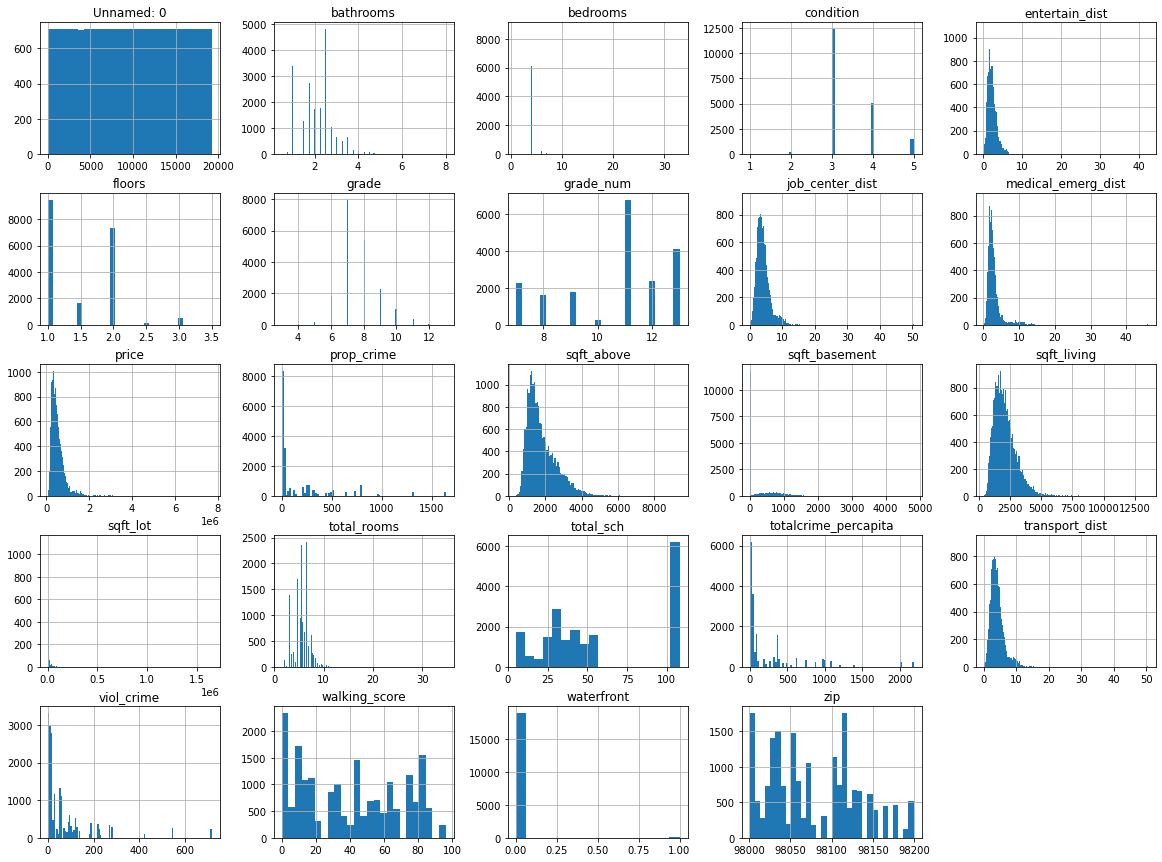

In [18]:
df.hist(bins='auto', figsize=[20,15]);

Features like distance (entertainment, medical emergency, job center, and transportation), square footage above ground, and square footage of living space seem to follow a slightly right-skewed distribution. When we add a total rooms section, it seems to follow a normal distribution as well. Walking score and criminality data don't seem to follow much of a distribution, so it may be hard use that data to predict housing price, but we can see what happens once we normalize it. We'll want to normalize all our continuous variables to best follow our assumptions. Waterfront, condition, bathrooms, bedrooms, and floors all seem to be categorical, so we'll make dummies for those as well. 

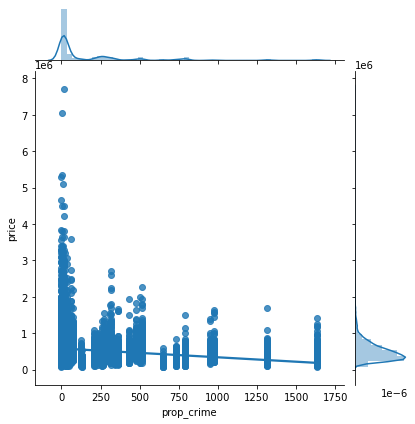

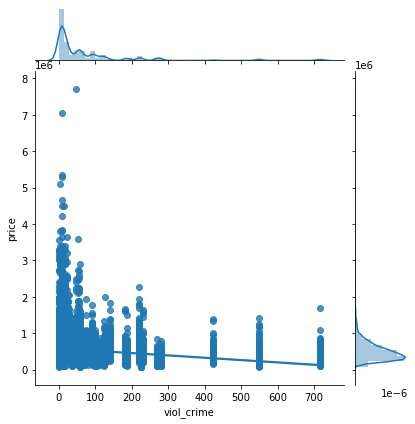

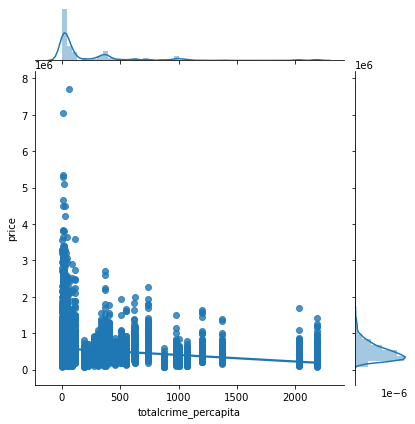

In [19]:
# import necessary libraries
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

sns.jointplot('prop_crime','price', data=df, kind='reg')
sns.jointplot('viol_crime', 'price', data=df, kind='reg')
sns.jointplot('totalcrime_percapita', 'price', data=df, kind='reg');

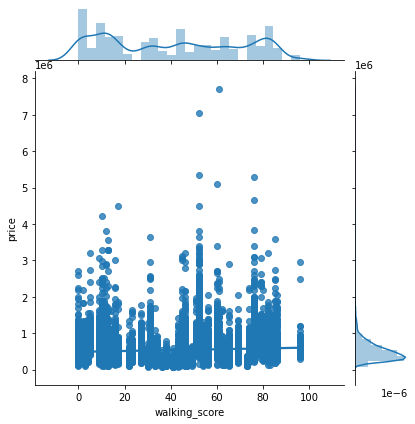

In [20]:
sns.jointplot('walking_score', 'price', data=df, kind='reg');

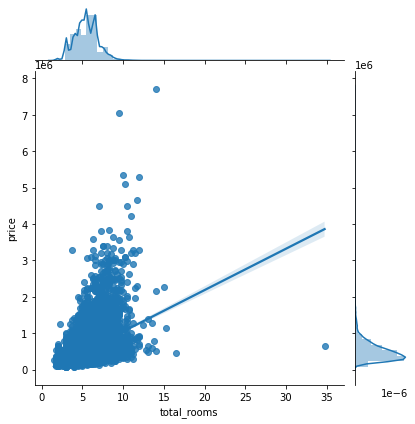

In [21]:
sns.jointplot('total_rooms', 'price', data=df, kind='reg');

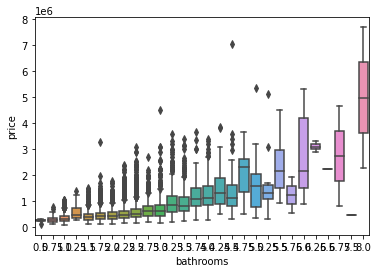

In [22]:
sns.boxplot('bathrooms', 'price', data=df);

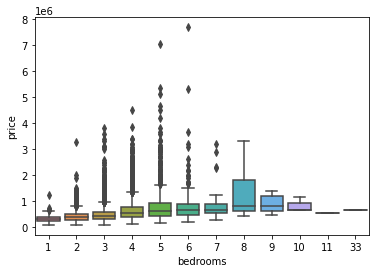

In [23]:
sns.boxplot('bedrooms', 'price', data=df);

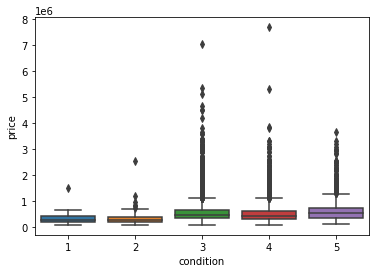

In [24]:
sns.boxplot('condition', 'price', data=df);

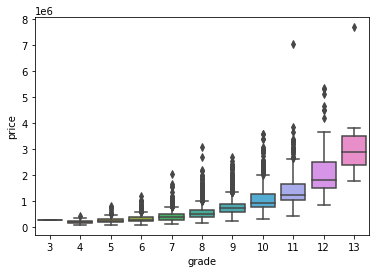

In [25]:
sns.boxplot('grade', 'price', data=df);

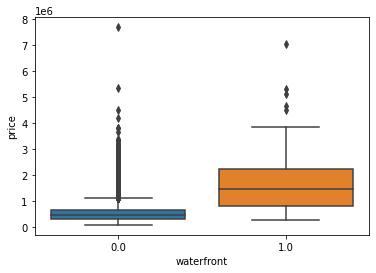

In [26]:
sns.boxplot('waterfront', 'price', data=df);

Upon initial investigations, it looks like waterfront and grade have a major impact on price. Crime rate looks to have a slight negative relationship with price, and walking score did not as clear linear relationship as I'd hope. We'll go ahead and deal with our categorical data, move to build an intial linear regression model, then move on from there. 

### Dealing with Categorical Variables

In [27]:
# Make a list of continuous variables and categorical variables 
cont = ['sqft_lot', 'sqft_living', 'sqft_above', 'sqft_basement', 'transport_dist', 'medical_emerg_dist', 'entertain_dist', 'job_center_dist', 'prop_crime', 'viol_crime', 'totalcrime_percapita', 'total_rooms', 'walking_score']
cat = ['waterfront' , 'condition', 'grade', 'district', 'grade_num']

In [28]:
waterfront_dummy = pd.get_dummies(df.waterfront, prefix='waterfront', drop_first=True)
condition_dummy = pd.get_dummies(df.condition, prefix='condition', drop_first=True)
grade_dummy = pd.get_dummies(df.grade, prefix='grade', drop_first=True)
district_dummy = pd.get_dummies(df.district, prefix='district', drop_first=True)
school_grade_dummy = pd.get_dummies(df.grade_num, prefix='school_grade', drop_first=True)
processed_data = pd.concat([df, waterfront_dummy, condition_dummy, grade_dummy, district_dummy, school_grade_dummy], axis=1)

processed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19176 entries, 0 to 19220
Data columns (total 65 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  19176 non-null  int64  
 1   price                       19176 non-null  float64
 2   bedrooms                    19176 non-null  int64  
 3   bathrooms                   19176 non-null  float64
 4   sqft_lot                    19176 non-null  int64  
 5   sqft_living                 19176 non-null  int64  
 6   floors                      19176 non-null  float64
 7   waterfront                  19176 non-null  float64
 8   condition                   19176 non-null  int64  
 9   grade                       19176 non-null  int64  
 10  sqft_above                  19176 non-null  int64  
 11  sqft_basement               19176 non-null  float64
 12  district                    19176 non-null  object 
 13  grades                      191

In [29]:
processed_data = processed_data.drop(['waterfront', 'condition', 'grade', 'district', 'grade_num'], axis=1)
processed_data.columns = processed_data.columns.str.replace('.', '_')
processed_data.head()

,Unnamed: 0,price,bedrooms,bathrooms,sqft_lot,sqft_living,floors,sqft_above,sqft_basement,grades,...,district_snoqualmie valley,district_tahoma,district_tukwila,district_vashon island,school_grade_8,school_grade_9,school_grade_10,school_grade_11,school_grade_12,school_grade_13
0,0,538000.0,3,2.25,7242,2570,2.0,2170,400.0,A-,...,0,0,0,0,0,0,0,1,0,0
1,1,180000.0,2,1.00,10000,770,1.0,770,0.0,A,...,0,0,0,0,0,0,0,0,1,0
2,2,604000.0,4,3.00,5000,1960,1.0,1050,910.0,A-,...,0,0,0,0,0,0,0,1,0,0
3,3,510000.0,3,2.00,8080,1680,1.0,1680,0.0,A+,...,0,0,0,0,0,0,0,0,0,1
4,4,1230000.0,4,4.50,101930,5420,1.0,3890,1530.0,A+,...,0,0,0,0,0,0,0,0,0,1


In [30]:
processed_data.columns = processed_data.columns.str.replace('.', '_')
processed_data.columns = processed_data.columns.str.replace(' ', '_')
processed_data.drop('Unnamed:_0', axis=1, inplace=True)
processed_data.head()

,price,bedrooms,bathrooms,sqft_lot,sqft_living,floors,sqft_above,sqft_basement,grades,total_sch,...,district_snoqualmie_valley,district_tahoma,district_tukwila,district_vashon_island,school_grade_8,school_grade_9,school_grade_10,school_grade_11,school_grade_12,school_grade_13
0,538000.0,3,2.25,7242,2570,2.0,2170,400.0,A-,108,...,0,0,0,0,0,0,0,1,0,0
1,180000.0,2,1.00,10000,770,1.0,770,0.0,A,39,...,0,0,0,0,0,0,0,0,1,0
2,604000.0,4,3.00,5000,1960,1.0,1050,910.0,A-,108,...,0,0,0,0,0,0,0,1,0,0
3,510000.0,3,2.00,8080,1680,1.0,1680,0.0,A+,55,...,0,0,0,0,0,0,0,0,0,1
4,1230000.0,4,4.50,101930,5420,1.0,3890,1530.0,A+,55,...,0,0,0,0,0,0,0,0,0,1


### Multicollinearity

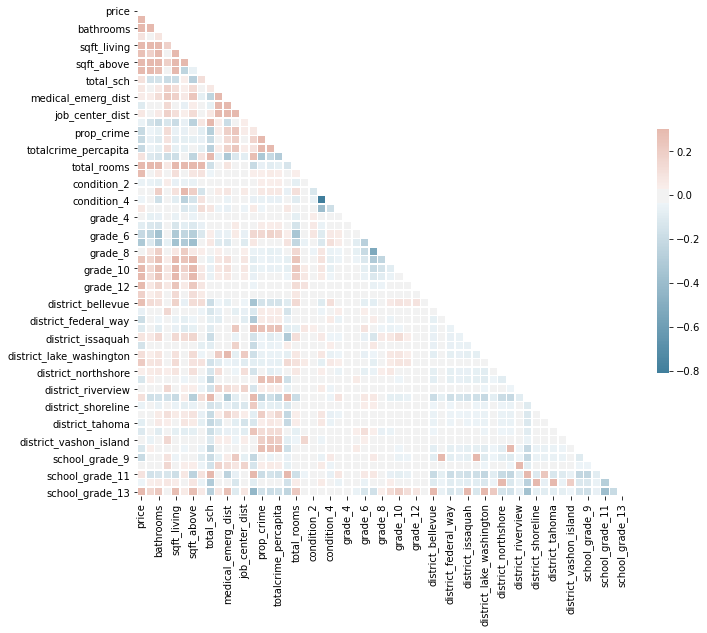

In [31]:
#check for multicollinearity 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = processed_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5});

In [32]:
## Code not running properly - check again soon 

corr_df= processed_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))
#corr_df.set_index(['pairs'], inplace= True)
#corr_df.drop(columns=['level_1', 'level_0'], inplace= True)
#corr_df.columns= ['cc']
#corr_df.drop_duplicates(inplace=True)

#corr_df[(df.cc> .75) & (df.cc< 1)]

### Model - v1 

In [33]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

train, test = train_test_split(processed_data)

outcome = 'price'
x_cols = list(processed_data.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model_1 = ols(formula=formula, data=train).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     992.9
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:58:25   Log-Likelihood:            -1.9383e+05
No. Observations:               14382   AIC:                         3.877e+05
Df Residuals:                   14336   BIC:                         3.881e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -8.316e+06   5.38e+06     -1.546      0.122   -1.89e+07    2.23e+06
grades[T.A+]               -1.013e+06   7.02e+05     -1.444      0.149   -2.39e+06    3.62e+05
grades[T.A-]               -3.677e+05   2.51e+05     -1.464      0.143    -8.6e+05    1.25e+05
grades[T.B]                -1.214e+06   7.58e+05     -1.601      0.109    -2.7e+06    2.72e+05
grades[T.B+]               -9.332e+05   6.08e+05     -1.536      0.125   -2.12e+06    2.58e+05
grades[T.B-]               -6.967e+05   4.45e+05     -1.564      0.118   -1.57e+06    1.76e+05
grades[T.C+]               -1.626e+06   1.03e+06     -1.584      0.113   -3.64e+06    3.85e+05
total_student[T.16,425]    -6.967e+05   4.45e+05     -1.564      0.118   -1.57e+06    1.76e+05
total_student[T.17,505]    -6.908e+05    4.3e+05     -1.606      0.108   -1.53e+06    1.52e+05
total_student[T.19,213]    -2.938e+05   2.02e+05     -1.452      0.147    -6.9e+05    1.03e+05
total_student[T.20,897]    -3.765e+05   2.21e+05     -1.706      0.088   -8.09e+05     5.6e+04
total_student[T.21,609]    -1.741e+05   1.54e+05     -1.134      0.257   -4.75e+05    1.27e+05
total_student[T.23,489]     -2.04e+05   9.73e+04     -2.096      0.036   -3.95e+05   -1.32e+04
total_student[T.23500]      1.278e+05   6.84e+04      1.868      0.062   -6309.776    2.62e+05
total_student[T.27,291]     1.596e+05   1.14e+05      1.404      0.160   -6.32e+04    3.82e+05
total_student[T.3,046]     -1.128e+06   7.26e+05     -1.553      0.121   -2.55e+06    2.96e+05
total_student[T.3,482]     -9.332e+05   6.08e+05     -1.536      0.125   -2.12e+06    2.58e+05
total_student[T.30,675]      3.13e+05   2.37e+05      1.318      0.188   -1.53e+05    7.78e+05
total_student[T.4,183]     -6.824e+05   4.42e+05     -1.545      0.122   -1.55e+06    1.83e+05
total_student[T.4,522]     -7.753e+05   5.65e+05     -1.372      0.170   -1.88e+06    3.32e+05
total_student[T.55,271]     1.041e+06    6.5e+05      1.601      0.109   -2.34e+05    2.32e+06
total_student[T.7,214]     -1.409e+06   9.01e+05     -1.563      0.118   -3.18e+06    3.58e+05
total_student[T.8,906]      -6.76e+05   4.21e+05     -1.605      0.109    -1.5e+06     1.5e+05
total_student[T.9,899]     -3.811e+05   2.63e+05     -1.447      0.148   -8.97e+05    1.35e+05
bedrooms                   -1.763e+04   1948.523     -9.047      0.000   -2.14e+04   -1.38e+04
bathrooms                   1.778e+04   2430.439      7.316      0.000     1.3e+04    2.25e+04
sqft_lot                       0.2708      0.038      7.084      0.000       0.196       0.346
sqft_living                  123.2092     18.850      6.536      0.000      86.261     160.157
floors                     -3.007e+04   3899.266     -7.711      0.000   -3.77e+04   -2.24e+04
sqft_above                    52.8849     1

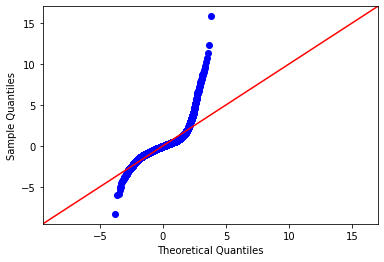

In [34]:
fig = sm.graphics.qqplot(model_1.resid, dist=stats.norm, line='45', fit=True)

Initial R-squared has a value of .76. Our omnibus for this model is pretty high given we haven't done much to our data and it doesn't follow our 3 assumptions. 

### Model - v2

In [41]:
# Create different dataframes to iterate through 
log_df = processed_data.copy(deep=True)
#minmax_df = processed_data 
#standardized_df = processed_data
#meannormalized_df = processed_data

In [45]:
import numpy as np
cont = ['price', 'sqft_lot', 'sqft_living', 'sqft_above', 'transport_dist', 'medical_emerg_dist', 'entertain_dist', 'job_center_dist', 'prop_crime', 'viol_crime', 'totalcrime_percapita', 'total_rooms', 'walking_score']
for feat in cont:
    try: 
        log_df[feat] = log_df[feat].map(lambda x: np.log(x))
    except: 
        log_df[feat] = log_df[feat]
    
log_df.head()

<ipython-input-45-b85e618bbb8d>:5: RuntimeWarning: invalid value encountered in log
  log_df[feat] = log_df[feat].map(lambda x: np.log(x))


,price,bedrooms,bathrooms,sqft_lot,sqft_living,floors,sqft_above,sqft_basement,grades,total_sch,...,district_snoqualmie_valley,district_tahoma,district_tukwila,district_vashon_island,school_grade_8,school_grade_9,school_grade_10,school_grade_11,school_grade_12,school_grade_13
0,2.579884,3,2.25,2.184663,2.060725,2.0,2.038943,400.0,A-,108,...,0,0,0,0,0,0,0,1,0,0
1,2.493264,2,1.00,2.220327,1.894074,1.0,1.894074,0.0,A,39,...,0,0,0,0,0,0,0,0,1,0
2,2.588616,4,3.00,2.142087,2.025606,1.0,1.939683,910.0,A-,108,...,0,0,0,0,0,0,0,1,0,0
3,2.575826,3,2.00,2.196908,2.005061,1.0,2.005061,0.0,A+,55,...,0,0,0,0,0,0,0,0,0,1
4,2.640665,4,4.50,2.445129,2.151512,1.0,2.112171,1530.0,A+,55,...,0,0,0,0,0,0,0,0,0,1


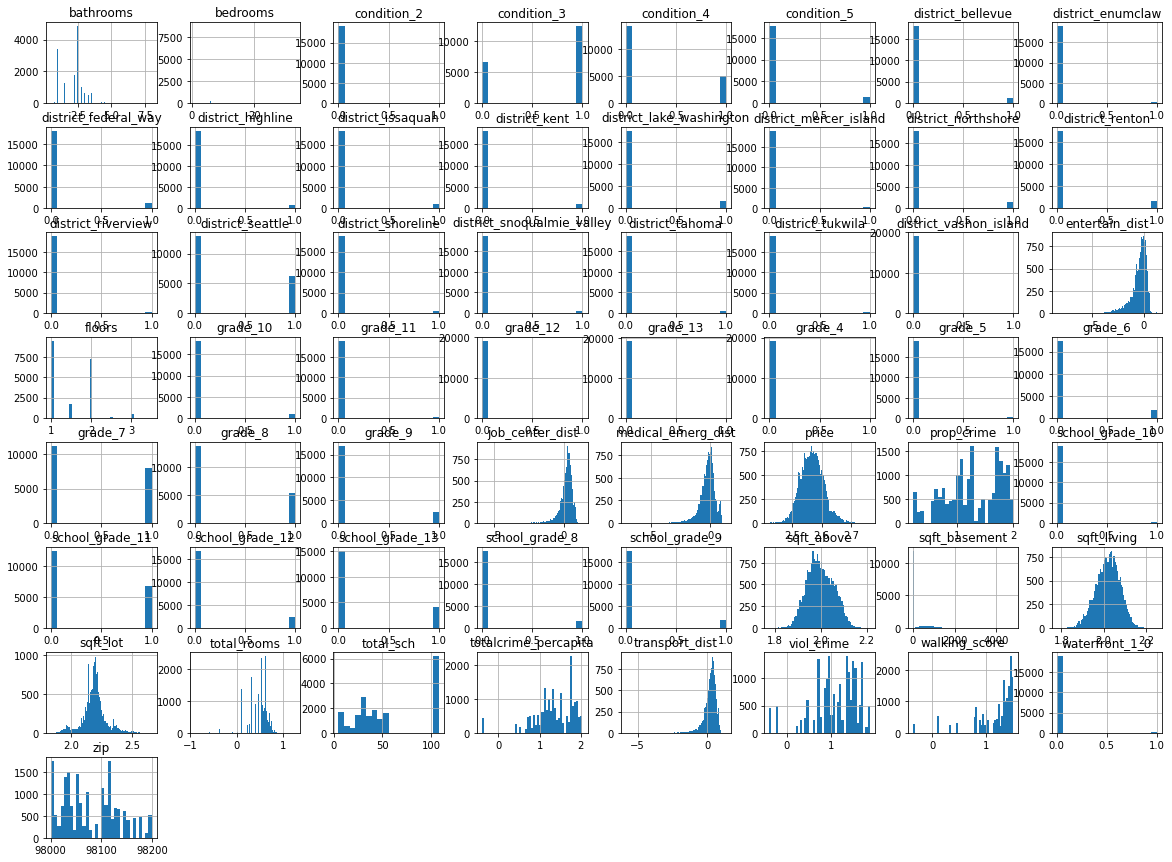

In [46]:
log_df.hist(bins='auto', figsize=[20,15]);

In [47]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

train_2, test_2 = train_test_split(log_df)

outcome = 'price'
x_cols = list(log_df.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model_2 = ols(formula=formula, data=train_2).fit()
model_2.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     1048.
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:04:30   Log-Likelihood:                 27196.
No. Observations:               10164   AIC:                        -5.430e+04
Df Residuals:                   10118   BIC:                        -5.397e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      4.4113      0.542      8.143      0.000       3.349       5.473
grades[T.A+]                   0.4798      0.058      8.313      0.000       0.367       0.593
grades[T.A-]                   0.1800      0.022      8.367      0.000       0.138       0.222
grades[T.B]                    0.5467      0.068      8.035      0.000       0.413       0.680
grades[T.B+]                   0.5424      0.067      8.136      0.000       0.412       0.673
grades[T.B-]                   0.3829      0.047      8.125      0.000       0.291       0.475
grades[T.C+]                   0.8690      0.108      8.060      0.000       0.658       1.080
total_student[T.16,425]        0.3829      0.047      8.125      0.000       0.291       0.475
total_student[T.17,505]        0.5777      0.072      8.076      0.000       0.437       0.718
total_student[T.19,213]        0.1560      0.019      8.154      0.000       0.118       0.193
total_student[T.20,897]        0.3331      0.040      8.290      0.000       0.254       0.412
total_student[T.21,609]        0.2689      0.032      8.326      0.000       0.206       0.332
total_student[T.23,489]        0.0456      0.007      6.942      0.000       0.033       0.059
total_student[T.23500]        -0.0907      0.012     -7.570      0.000      -0.114      -0.067
total_student[T.27,291]       -0.0309      0.004     -8.814      0.000      -0.038      -0.024
total_student[T.3,046]         0.6674      0.082      8.127      0.000       0.506       0.828
total_student[T.3,482]         0.5424      0.067      8.136      0.000       0.412       0.673
total_student[T.30,675]       -0.1222      0.015     -8.280      0.000      -0.151      -0.093
total_student[T.4,183]      2.665e-14   3.29e-15      8.111      0.000    2.02e-14    3.31e-14
total_student[T.4,522]      6.509e-14   7.97e-15      8.165      0.000    4.95e-14    8.07e-14
total_student[T.55,271]       -0.6709      0.083     -8.130      0.000      -0.833      -0.509
total_student[T.7,214]         0.8509      0.104      8.180      0.000       0.647       1.055
total_student[T.8,906]         0.3802      0.047      8.096      0.000       0.288       0.472
total_student[T.9,899]         0.2260      0.028      8.106      0.000       0.171       0.281
bedrooms                      -0.0002      0.000     -0.644      0.520      -0.001       0.000
bathrooms                      0.0035      0.000      7.529      0.000       0.003       0.004
sqft_lot                       0.0461      0.003     16.739      0.000       0.041       0.051
sqft_living                    0.1982      0.015     13.519      0.000       0.169       0.227
floors                        -0.0011      0.001     -2.235      0.025      -0.002      -0.000
sqft_above                     0.0984      

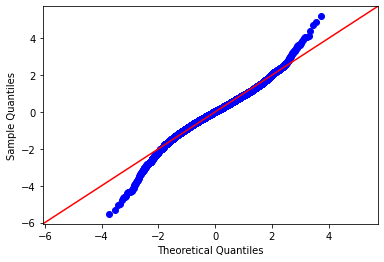

In [48]:
fig = sm.graphics.qqplot(model_2.resid, dist=stats.norm, line='45', fit=True)

When we performed a log transformation for our continuous variables, our R-squared value went up to .826 and our omnibus is 92.952. We do find that many features have a p-value of more than 0.05, so we'll want to eliminate those in order to figure out which features play the biggest role in price. 

Use stepwise selection to select appropriate values 
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
#X = log_df.drop('price', axis=1)
#y = log_df['price']

#result = stepwise_selection(X, y, verbose = True)
#print('resulting features:')
#print(result)


#predictors_df = log_df.drop('price', axis=1)
#result = stepwise_selection(predictors_df, log_df['price'], verbose=True)
#print('resulting features:')
#print(result)

In [ ]:
#corr_df= processed_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
#corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))
#corr_df.set_index(['pairs'], inplace= True)
#corr_df.drop(columns=['level_1', 'level_0'], inplace= True)
#corr_df.columns= ['cc']
#corr_df.drop_duplicates(inplace=True)

#corr_df[(df.cc> .75) & (df.cc< 1)]

### Model - v3 

In [52]:
min_max_df = processed_data.copy(deep=True)

def min_max_scaling(df_column):
    x = (df_column - min(df_column))/ (max(df_column) - min(df_column))
    return x 

cont_features = ['price', 'totalcrime_percapita','sqft_lot', 'sqft_living', 'total_rooms', 'transport_dist', 'medical_emerg_dist', 'entertain_dist', 'job_center_dist', 'sqft_basement']

for feat in cont_features:
    min_max_df[feat] = min_max_scaling(min_max_df[feat])
    
min_max_df.head()

,price,bedrooms,bathrooms,sqft_lot,sqft_living,floors,sqft_above,sqft_basement,grades,total_sch,...,district_snoqualmie_valley,district_tahoma,district_tukwila,district_vashon_island,school_grade_8,school_grade_9,school_grade_10,school_grade_11,school_grade_12,school_grade_13
0,0.060352,3,2.25,0.004072,0.167046,2.0,2170,0.082988,A-,108,...,0,0,0,0,0,0,0,1,0,0
1,0.013382,2,1.00,0.005743,0.030372,1.0,770,0.000000,A,39,...,0,0,0,0,0,0,0,0,1,0
2,0.069011,4,3.00,0.002714,0.120729,1.0,1050,0.188797,A-,108,...,0,0,0,0,0,0,0,1,0,0
3,0.056678,3,2.00,0.004579,0.099468,1.0,1680,0.000000,A+,55,...,0,0,0,0,0,0,0,0,0,1
4,0.151141,4,4.50,0.061429,0.383447,1.0,3890,0.317427,A+,55,...,0,0,0,0,0,0,0,0,0,1


In [53]:
train_3, test_3 = train_test_split(log_df)

outcome = 'price'
x_cols = list(log_df.columns)
x_cols.remove(outcome)

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model_3 = ols(formula=formula, data=train_3).fit()
model_3.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     1039.
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:11:11   Log-Likelihood:                 27156.
No. Observations:               10137   AIC:                        -5.422e+04
Df Residuals:                   10091   BIC:                        -5.389e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      4.2497      0.522      8.147      0.000       3.227       5.272
grades[T.A+]                   0.4626      0.056      8.323      0.000       0.354       0.572
grades[T.A-]                   0.1729      0.021      8.350      0.000       0.132       0.214
grades[T.B]                    0.5263      0.066      8.033      0.000       0.398       0.655
grades[T.B+]                   0.5231      0.064      8.149      0.000       0.397       0.649
grades[T.B-]                   0.3689      0.045      8.130      0.000       0.280       0.458
grades[T.C+]                   0.8367      0.104      8.059      0.000       0.633       1.040
total_student[T.16,425]        0.3689      0.045      8.130      0.000       0.280       0.458
total_student[T.17,505]        0.5567      0.069      8.082      0.000       0.422       0.692
total_student[T.19,213]        0.1497      0.018      8.129      0.000       0.114       0.186
total_student[T.20,897]        0.3212      0.039      8.302      0.000       0.245       0.397
total_student[T.21,609]        0.2592      0.031      8.334      0.000       0.198       0.320
total_student[T.23,489]        0.0437      0.006      6.908      0.000       0.031       0.056
total_student[T.23500]        -0.0875      0.012     -7.588      0.000      -0.110      -0.065
total_student[T.27,291]       -0.0303      0.003     -8.969      0.000      -0.037      -0.024
total_student[T.3,046]         0.6432      0.079      8.134      0.000       0.488       0.798
total_student[T.3,482]         0.5231      0.064      8.149      0.000       0.397       0.649
total_student[T.30,675]       -0.1178      0.014     -8.290      0.000      -0.146      -0.090
total_student[T.4,183]      1.132e-14   1.42e-15      7.997      0.000    8.55e-15    1.41e-14
total_student[T.4,522]      5.985e-14   7.29e-15      8.212      0.000    4.56e-14    7.41e-14
total_student[T.55,271]       -0.6459      0.079     -8.129      0.000      -0.802      -0.490
total_student[T.7,214]         0.8188      0.100      8.175      0.000       0.622       1.015
total_student[T.8,906]         0.3661      0.045      8.095      0.000       0.277       0.455
total_student[T.9,899]         0.2181      0.027      8.122      0.000       0.165       0.271
bedrooms                    2.608e-06      0.000      0.007      0.994      -0.001       0.001
bathrooms                      0.0033      0.000      7.059      0.000       0.002       0.004
sqft_lot                       0.0461      0.003     17.016      0.000       0.041       0.051
sqft_living                    0.1894      0.014     13.128      0.000       0.161       0.218
floors                        -0.0010      0.001     -1.949      0.051      -0.002    5.41e-06
sqft_above                     0.0990      

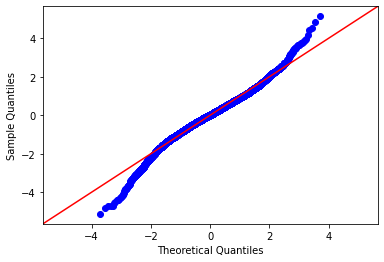

In [55]:
fig = sm.graphics.qqplot(model_3.resid, dist=stats.norm, line='45', fit=True)